In [133]:
import pandas as pd
from obspy.clients.fdsn import Client
from glob import glob
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

In [134]:
# Read in inviduual CSV files to get NET.STA codes
fns = glob("PaperZero_RMS/*.csv")

In [135]:
# Find latitude and longitude for each station. Use ad-hoc list based on ISC station registries for which some
# stations cannot be queried using FDSNWS
extra_stations = {"EFIU": {"lat": 37.78960, "lon": 15.21030},
                  "BER": {"lat": 60.38381, "lon": 5.33389},
                  "BTMR": {"lat": 44.43700, "lon": 26.10670},
                  "MNH": {"lat": 48.15000, "lon": 11.60000},
                  "THE": {"lat": 40.63220, "lon": 22.96500},
                  "GGERF": {"lat": 55.841139, "lon": -4.221389}}
sta_lats = []
sta_lons = []
sta_codes = []
for sta_csv in fns:
    net, sta, loc, cha, _ = sta_csv.split("/")[1].split(".")
    if sta in extra_stations.keys():
        sta_codes.append("{:}.{:}".format(net, sta))
        sta_lats.append(extra_stations[sta]["lat"])
        sta_lons.append(extra_stations[sta]["lon"])
    else:
        if net == "AM":
            cli = "RASPISHAKE"
        elif net == "CH":
            cli = "ETH"
        elif net == "NC":
            cli = "NCEDC"
        elif net in ["FR", "QM"]:
            cli = "RESIF"
        elif net in ["CQ", "HL"]:
            cli = "NOA"
        elif net in ["GE", "KV"]:
            cli = "GFZ"
        elif net == "IV":
            cli = "INGV"
        elif net == "BW":
            cli = "LMU"
        elif net == "OE":
            cli = "ORFEUS"
        elif net == "KO":
            cli = "KOERI"
        elif net in ["MD", "RO"]:
            cli = "NIEP"
        elif net == "NZ":
            cli = "GEONET"
        elif net == "NL":
            cli = "KNMI"
        elif net == "YS":
            #cli = "http://eida.ictja.csic.es"
            print("Could not get data for YS network")
            continue
        else:
            cli = "IRIS"
        client = Client(cli)
        try:
            inv = client.get_stations(network=net, station=sta)
        except:
            print("Could not find info for {:}.{:}".format(net, sta))
            continue
        sta_lats.append(inv[0][0].latitude)
        sta_lons.append(inv[0][0].longitude)
        sta_codes.append("{:}.{:}".format(net, sta))

Could not get data for YS network
Could not find info for QM.KNKL
Could not get data for YS network


In [138]:
# Merge latitudes and longitudes into existing dataframe
d = []
a = pd.DataFrame()
a["latitude"] = sta_lats
a["longitude"] = sta_lons
a["sta_code"] = sta_codes

orig_df = pd.read_csv("Paper Zero - Station Information - Blad1.csv")
new_merged = orig_df.merge(a, left_on="Station_Code", right_on="sta_code")
new_merged.drop(["sta_code"], axis=1)
new_merged.to_csv("StationInformationLatsLons.csv")

                              Name Country name Country code           City  \
0                    Stephen Hicks     Barbados           BB     Bridgetown   
1    Thomas Lecocq; Koen Van Noten      Belgium           BE       Brussels   
2                  William Minarik       Canada           CA       Montreal   
3                  William Minarik       Canada           CA      Vancouver   
4                  William Minarik       Canada           CA        Toronto   
..                             ...          ...          ...            ...   
97                    Javier Ojeda       Brasil           BR      Sao Paulo   
98                  Taka'aki Taira          NaN           US  San Francisco   
99                  Taka'aki Taira          NaN           US          Ukiah   
100              Paula Koelemeijer        Japan           JP          Tokyo   
101              Paula Koelemeijer        Japan           JP          Tokyo   

           FDSN Station_Code                       

[-23.002199, 22.277599, 53.24519, 8.794, 68.7027027, 47.377497, -89.9289, 37.636761, 41.379251, 28.40540541, 46.94582, -20.898865, 48.8445, 9.939, 35.141, 37.87622, -22.993059, -1.681242, 49.6646, 37.7896, 47.416309, 25.566816, 42.3012, 46.01038, 8.72972973, 47.2867, 37.74774775, 42.84684685, 42.33333333, -33.9297, 34.019192, 41.1712, -34.880901, 48.2483, -17.909599, 35.64864865, 42.12612613, 60.38381, 47.463, 46.20062, 41.3844, 29.7031, 5.954954955, 51.44144144, -7.04915, 62.18018018, -7.9125, 14.58501, 28.06306306, 13.1434, 56.94594595, -3.396068, -37.968399, 40.7402, 49.28828829, 43.774366, 30.2762, 22.26126126, 19.0291, 27.7027027, 46.16384, -34.919399, 35.6036036, 43.63963964, 44.437, 45.5003, -37.968399, 37.87352, 55.923328, 48.15, -36.85013, 55.841139, 37.642929, 45.4803, 40.8382, 42.33333333, 40.7911, 11.655733, 57.16216216, 46.521239, -11.9875, 42.27027027, 50.797241, 27.3963964, 14.9702, -33.4631, 37.271133, 52.633821, 39.18918919, 36.8998, 50.25225225, 27.6036036, 37.97384, 

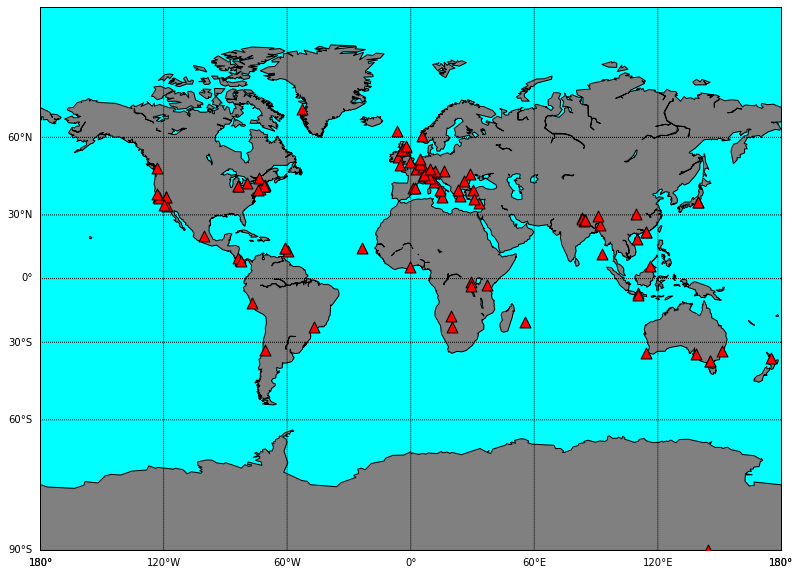

In [137]:
# Now make a basic map
fig = plt.figure(figsize=(14,10))
map = Basemap(projection='mill',lon_0=0)
# plot coastlines, draw label meridians and parallels.
map.drawcoastlines()
map.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0])
map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=[0,0,0,1])
map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='gray',lake_color='aqua')
x, y = map(sta_lons, sta_lats)
plt.scatter(x,y,120,marker='^',color='Red', zorder=10, edgecolor="k")
#for label, xpt, ypt in zip(sta_codes, x, y):
    #plt.text(xpt, ypt, label, zorder=20, color="white", fontsize=8)
plt.show()